# Nicolas
---

## Importing stuff

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

---
## Loading data

* **route**

In [2]:
routes = pd.read_csv('data/routes.dat', sep=',', encoding='utf-8')
routes.columns = ['Airline','AirlineID','SourceAirport','SourceAirportID','DestinationAirport','DestinationAirportID','Codeshare','Stops','Equipment']
routes.head(2)

,Airline,AirlineID,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment
0,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,MRV,2962,NaN,0,CR2


* **airlines**

In [3]:
airlines = pd.read_csv('data/airlines.dat', sep=',', encoding='utf-8')
airlines.columns = ['AirlineID', 'Name', 'Alias',  'IATA', 'ICAO','Callsign','Country','Active']
airlines.head(2)

,AirlineID,Name,Alias,IATA,ICAO,Callsign,Country,Active
0,1,Private flight,\N,-,NaN,NaN,NaN,Y
1,2,135 Airways,\N,NaN,GNL,GENERAL,United States,N


* **airports**

In [4]:
airports = pd.read_csv('data/airports.dat', sep=',', encoding='utf-8')
airports.columns = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO','Latitude','Longitude','Altitude', 'Timezone','DST', 'TzdatabaseTimeZone', 'Type', 'Source']
airports.head(2)

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzdatabaseTimeZone,Type,Source
0,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
1,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.82679,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports


* **alliances**

In [5]:
alliances = pd.read_csv('data/alliances.dat', sep=',', encoding='utf-8')
alliances.head(2)

,Alliance,IATA,Region
0,Star Alliance,JP,Europe
1,Star Alliance,A3,Europe


In [6]:
alliances.shape

(60, 3)

All the airlines from `alliances.dat` now have a correspondance in the airlines data base with the rigth name.

---
## Creating some array

From Marie's work :

In [7]:
airl_alliances  = pd.merge(alliances, airlines, left_on='IATA', right_on='IATA', how = 'left')[['Alliance', 'Name', 'IATA', 'Country']]
airl_alliances.head(2)

,Alliance,Name,IATA,Country
0,Star Alliance,Adria Airways,JP,Slovenia
1,Star Alliance,Aegean Airlines,A3,Greece


In [8]:
routes_alce = pd.merge(routes, airl_alliances, left_on = 'Airline', right_on = 'IATA', how = 'left')
routes_alce.head(2)

,Airline,AirlineID,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment,Alliance,Name,IATA,Country
0,2B,410,ASF,2966,KZN,2990,NaN,0,CR2,NaN,NaN,NaN,NaN
1,2B,410,ASF,2966,MRV,2962,NaN,0,CR2,NaN,NaN,NaN,NaN


In [9]:
routes_alce[~routes_alce.IATA.isnull()].Airline.count()

31134

In [10]:
routes_alce_only = routes_alce[~routes_alce.IATA.isnull()]
routes_alce_only.head(2)

,Airline,AirlineID,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment,Alliance,Name,IATA,Country
4237,A3,96,AOK,1459,ATH,3941,NaN,0,DH4,Star Alliance,Aegean Airlines,A3,Greece
4238,A3,96,AOK,1459,KSJ,1461,NaN,0,DH8,Star Alliance,Aegean Airlines,A3,Greece


---
## Adjacency matrices

Here I'm just replacing the nan by a "None" string to simplify comparison later.

In [11]:
routes_alce = routes_alce.fillna("None")
routes_alce.head(2)

,Airline,AirlineID,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment,Alliance,Name,IATA,Country
0,2B,410,ASF,2966,KZN,2990,None,0,CR2,None,None,None,None
1,2B,410,ASF,2966,MRV,2962,None,0,CR2,None,None,None,None


Recreation of the indexes for the destinations and sources airport adapted from milestone 1.

In [12]:
# import of source and destination airport
source_airports = routes[['SourceAirport']]
source_airports = source_airports.rename(columns={'SourceAirport':'Airport'})

dest_airports = routes[['DestinationAirport']]
dest_airports = dest_airports.rename(columns={'DestinationAirport':'Airport'})

# creation of a dataframe with all airport and airport_idx 
# (we use airport_idx insteed of airportID because some airports have no airportID)
airportsID = pd.concat([source_airports,dest_airports]).drop_duplicates().reset_index().drop(columns=['index']).reset_index()
airportsID = airportsID.set_index('Airport').rename(columns={'index':'airportsID'})
airportsID.head(2)

,airportsID
Airport,
ASF,0
CEK,1


Creation of the weighted adjacency matrix. We first create a 3D tensor with dimensions {source, destination, alliance}. That way we can keep the weight intact for each flight.
* No edges = 0
* No alliances = 1
* Star Alliance = 2
* One World = 3
* SkyTeam = 4

In [13]:
alliances_idx = {"None":1, "Star Alliance":2, "One World":3, "SkyTeam":4}
alliances_idx["None"]

1

In [14]:
n_nodes = len(airportsID)
adjacency = np.zeros((n_nodes, n_nodes, 5), dtype=int)
for idx,row in routes_alce.iterrows():
    
    idx_source = airportsID.loc[row.SourceAirport, "airportsID"]
    idx_dest = airportsID.loc[row.DestinationAirport, "airportsID"]
    category = alliances_idx[row.Alliance]
    
    adjacency[idx_source, idx_dest, category] += 1
    adjacency[idx_dest, idx_source, category] += 1

For exemple, this is the adjacency of the first 15 airports that are not in any alliances and then from SkyTeam.

In [15]:
# view of a part of adjacency
print(adjacency[:15, :15, 1])
print(adjacency[:15, :15, 4])

[[ 0  0  2  0  0  0  2  2  2  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  2  0  0  0  0  0  4  0  0]
 [ 2  2  0  6  2  4  6  6  4  2  2  4  4  4  2]
 [ 0  0  6  0  0  2  2  2  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  2  2  2  0  0  2  4  0]
 [ 0  0  4  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  2  6  2  0  0  0  4  0  0  0  0  0  2  0]
 [ 2  0  6  2  2  0  4  0  0  2  0  0  2  2  0]
 [ 2  0  4  0  2  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  2  0  2  0  0  2  0  0  0  0  0  2  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  6  4  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  2  4  0]
 [ 0  4  4  0  2  0  0  2  0  0  6  2  0 10  0]
 [ 0  0  4  0  4  0  2  2  4  2  4  4 10  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 2 2 0 2 2 2 0 2 0 0 0 2 2 0]
 [0 0 0 0 0 0 0

We may want to flatten this array. We can associate each travel (source, destination) with the alliance that have the most flight on it :

In [16]:
MaXdjacency = np.argmax(adjacency, axis=2)
print("This is indeed a" , MaXdjacency.shape, "matrix.")
MaXdjacency[:15, :15]

This is indeed a (3425, 3425) matrix.


array([[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 4, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [1, 4, 1, 1, 1, 4, 1, 0, 4, 1, 0, 0, 1, 1, 0],
       [1, 0, 1, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [17]:
print("The number of edges is now", (MaXdjacency != 0).sum())
print("The number of edges from an alliances is now", np.logical_and((MaXdjacency != 0),(MaXdjacency != 1)).sum())

The number of edges is now 38513
The number of edges from an alliances is now 11264


**Note :** The selection of the label for each flight by the argmax can be unfair because there are many more airlines that are not in alliances and therefore possibly higther weigth for the "None" category. Other methods can be found. For exemples we could normalize by the number of airlines by category for each fligth. We can discuss that. But the whole information is anyway in the 3D adjacency.

---
## Some tests for later

Paris's main airport is Paris Charles de Gaulle (CDG). Let's see the connection of that airport.

In [18]:
cdg_idx = airportsID.loc["CDG", "airportsID"]

Text(0.5, 1.0, 'Number of flight by alliances in the CDG airport')

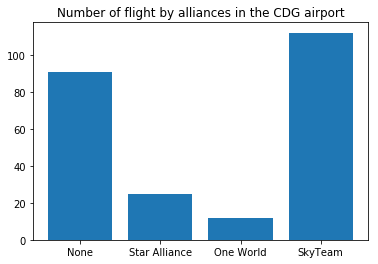

In [19]:
#height,x = np.histogram(MaXdjacency[cdg_idx, :], [0, 1, 2, 3, 4])

y = np.bincount(MaXdjacency[cdg_idx, :])[1:] # To ignore the 0 where ther is no edge
plt.xticks(list(alliances_idx.values()), list(alliances_idx.keys()))
plt.bar(list(alliances_idx.values()), y)
plt.title("Number of flight by alliances in the CDG airport")

We can then say that this airport is "controled" by SkyTeam. This seems reasonable as AirFrance is indeed in this alliance.

Now let's assign each airport with a alliance tag :

In [20]:
airport_tag = np.zeros(airportsID.size, dtype = int)
for name,airport in airportsID.iterrows():
    counts = np.bincount(MaXdjacency[airport.airportsID, :])[1:]
    values = np.unique(MaXdjacency[airport.airportsID, :])
    values = list(range(values.min(), values.max()+1))[1:]
    maxi = np.argmax(counts)
    airport_tag[airport.airportsID] = values[maxi]

In [21]:
tags = np.array(list(alliances_idx.keys()))[airport_tag-1]
print(tags)

['None' 'None' 'None' ... 'None' 'None' 'None']


In [22]:
print(np.unique(tags))
print(np.unique(airport_tag))

['None' 'One World' 'SkyTeam' 'Star Alliance']
[1 2 3 4]


Text(0.5, 1.0, 'Number of airport controled by each alliances')

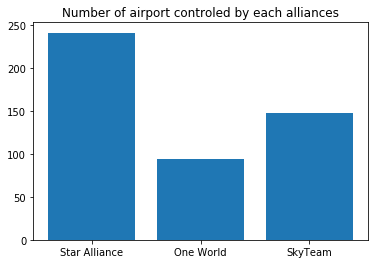

In [23]:
plt.xticks(list(alliances_idx.values())[1:], list(alliances_idx.keys())[1:])
plt.bar(list(alliances_idx.values())[1:],  np.bincount(airport_tag)[2:])
plt.title("Number of airport controled by each alliances")

---
## Projections and vizualisation

In [24]:
import folium
#pip install folium

First, let's create a map of the airports :

In [25]:
airports.head(2)

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,TzdatabaseTimeZone,Type,Source
0,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
1,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.82679,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports


In [26]:
airportsID.head(2)

,airportsID
Airport,
ASF,0
CEK,1


In [27]:
airportsID["IATA"] = airportsID.index
airportsID = airportsID.set_index("airportsID")

In [28]:
airportsID.head(2)

,IATA
airportsID,
0,ASF
1,CEK


In [29]:
geoData = pd.merge(airportsID, airports, left_on="IATA", right_on="IATA", how="left")[["IATA", "Name", "Latitude", "Longitude"]]
geoData = geoData.set_index("IATA")
geoData['alliance'] = airport_tag
geoData.head()

,Name,Latitude,Longitude,alliance
IATA,,,,
ASF,Astrakhan Airport,46.283298,48.006302,1
CEK,Chelyabinsk Balandino Airport,55.305801,61.503300,1
DME,Domodedovo International Airport,55.408798,37.906300,1
EGO,Belgorod International Airport,50.643799,36.590099,1
GYD,Heydar Aliyev International Airport,40.467499,50.046700,1


In [30]:
geoData[geoData["Name"].isnull()].shape

(239, 4)

In [31]:
colors = ['#969696', '#FF0000', '#00FF00', '#0000FF']

In [32]:
m = folium.Map()

In [33]:
for idx,row in geoData.sort_values("alliance").iterrows():
    #print(row.alliance)
    color = colors[row.alliance-1]
    if row.alliance>1:
        r = 7
    else:
        r = 1
    if pd.isna(row.Latitude) is False:
        folium.Circle(
            location=[row.Latitude, row.Longitude],
            radius=10000*r,
            color=color,
            stroke=False,
            fill=True,
            fill_opacity=0.6,
            tooltip=row.Name
        ).add_to(m)

All the airport are plot in the following map

In [34]:
m

In [35]:
m.save('airportscolored.html')

Now the edges : (Don't run that with a potato PC)

In [36]:
kw = {'opacity':0.1, 'weight': 0.4}


for idx,row in routes.iterrows():
    Lat_s = geoData.loc[row.SourceAirport,"Latitude"]
    Lat_d = geoData.loc[row.DestinationAirport,"Latitude"]
    Long_s = geoData.loc[row.SourceAirport,"Longitude"]
    Long_d = geoData.loc[row.DestinationAirport,"Longitude"]
    if pd.isna(Lat_s) is False and pd.isna(Lat_d) is False:
        folium.PolyLine(
            locations=[(Lat_s, Long_s), (Lat_d, Long_d)],
            line_cap='butt',
            color='cornflowerblue',
            **kw,
        ).add_to(m)

In [37]:
#m

In [38]:
#m.save('airports_routes.html')